# Train and test AVIDNet

In [1]:
import torch
from torch.utils.data import DataLoader
import os
from torchsummary import summary
from collections import defaultdict
from datasets.transforms import get_data_transforms
from datasets.utils import separate_datasets, show_samples,CovidDataLoader
from models.model import get_model
from models.train import train_model
from models.metrics import update_mean_metrics, print_metrics
from models.utils import set_random_seed

## Set and get basic environments

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
random_seed = 0
set_random_seed(random_seed)

## Load data

In [4]:
cfg = {
    'purpose' : 'baseline',
    'data_dir' : './data/CXR/ori',
    'num_labeled': 25, #<- 코드 이름이 맞추기
    'mu' : 1,
    'fold' : 5,
    'epochs' : 20,
    'metric_types' : ['acc', 'ppv', 'recall', 'f1']
}
dataset_types = ['train', 'test']

if not os.path.exists(os.path.join(cfg['data_dir'],'test.txt')):
    from datasets.utils import make_baseline_dataset
    make_baseline_dataset(cfg['data_dir'], cfg['num_labeled'], outpath=cfg['data_dir']) # test는 전부, train은 25개 만큼만
    
if cfg['purpose'] == 'fixmatch' and not os.path.exists(os.path.join(cfg['data_dir'],'train_lb_0.txt')):
    from datasets.utils import separate_datasets
    separate_datasets(cfg['data_dir'], cfg['fold'], cfg['epochs'], cfg['mu'],outpath=cfg['data_dir']) # lb는 25개, ulb는 mu*25개     

### Test samples

In [5]:
sample_loader = CovidDataLoader('train', cfg, fold_id=0)
class_names = sample_loader.class_names

sample_loader = DataLoader(sample_loader, batch_size=1, num_workers=4, shuffle=True,
                           collate_fn=sample_loader.collate_fn)

In [6]:
class_names

{0: 'covid-19', 1: 'pneumonia', 2: 'normal'}

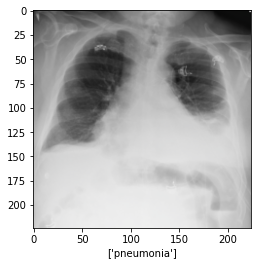

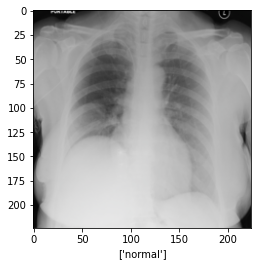

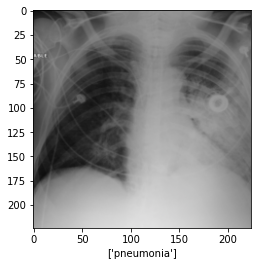

In [7]:
show_iteration = 3
show_samples(sample_loader, class_names, show_iteration, cfg['mu'])

## Train the model

### Training data constrained with the number of labeled data

In [ ]:
trained_models = []

mean_metrics = {m_type: defaultdict(float) for m_type in cfg['metric_types']}
test_loader = CovidDataLoader('test', cfg)
dataset_sizes ={'test':len(test_loader)}
class_names = list(test_loader.class_names.values())
metric_targets = ['all'] + class_names

test_loader = DataLoader(test_loader, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=test_loader.collate_fn)
data_loaders ={'test':test_loader}


for i in range(cfg['fold']):
    train_loaders = CovidDataLoader('train', cfg)
    dataset_sizes['train']=len(train_loaders)
    train_loaders = DataLoader(train_loaders, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=train_loaders.collate_fn)
    data_loaders['train']=train_loaders

    model_ft, criterion, optimizer_ft, exp_lr_scheduler = get_model(device, fine_tuning=False)
    model, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, i, class_names, metric_targets,
                                 cfg['metric_types'], dataset_types, data_loaders, dataset_sizes, device, num_epochs=20,
                                 lambda_u=1.0, threshold=0.95, purpose=cfg['purpose'], is_early=False)
    trained_models.append(model)
    mean_metrics = update_mean_metrics(metric_targets, mean_metrics, metrics, status='training')

mean_metrics = update_mean_metrics(metric_targets, mean_metrics, status='final', fold=cfg['fold'])
print_metrics(mean_metrics, metric_targets, phase='Mean results')

--------------------
Model 1
--------------------

Epoch 0/19
----------
[train]
LOSS - 0.5507
ACC - 0.7841
PPV - ALL: 0.7819  COVID-19: 0.7920  PNEUMONIA: 0.7412  NORMAL: 0.8125 
RECALL - ALL: 0.5956  COVID-19: 0.1915  PNEUMONIA: 0.7479  NORMAL: 0.8474 
F1 - ALL: 0.6275  COVID-19: 0.3084  PNEUMONIA: 0.7445  NORMAL: 0.8296 

[test]
LOSS - 0.3942
ACC - 0.8556
PPV - ALL: 0.8100  COVID-19: 0.7164  PNEUMONIA: 0.8339  NORMAL: 0.8796 
RECALL - ALL: 0.7416  COVID-19: 0.4800  PNEUMONIA: 0.8283  NORMAL: 0.9164 
F1 - ALL: 0.7678  COVID-19: 0.5748  PNEUMONIA: 0.8311  NORMAL: 0.8976 

Epoch 1/19
----------
[train]
LOSS - 0.4837
ACC - 0.8125
PPV - ALL: 0.8045  COVID-19: 0.8007  PNEUMONIA: 0.7737  NORMAL: 0.8390 
RECALL - ALL: 0.6888  COVID-19: 0.4275  PNEUMONIA: 0.7766  NORMAL: 0.8622 
F1 - ALL: 0.7276  COVID-19: 0.5574  PNEUMONIA: 0.7751  NORMAL: 0.8504 

[test]
LOSS - 0.3691
ACC - 0.8721
PPV - ALL: 0.8485  COVID-19: 0.8036  PNEUMONIA: 0.8554  NORMAL: 0.8866 
RECALL - ALL: 0.7445  COVID-19: 0.4500

### Training all data

In [9]:
trained_models = []

mean_metrics = {m_type: defaultdict(float) for m_type in cfg['metric_types']}
test_loader = CovidDataLoader('test', cfg)
dataset_sizes ={'test':len(test_loader)}
class_names = list(test_loader.class_names.values())
metric_targets = ['all'] + class_names

test_loader = DataLoader(test_loader, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=test_loader.collate_fn)
data_loaders ={'test':test_loader}


for i in range(cfg['fold']):
    train_loaders = CovidDataLoader('train', cfg)
    dataset_sizes['train']=len(train_loaders)
    train_loaders = DataLoader(train_loaders, batch_size=6, num_workers=4, shuffle=True,
                              collate_fn=train_loaders.collate_fn)
    data_loaders['train']=train_loaders

    model_ft, criterion, optimizer_ft, exp_lr_scheduler = get_model(device, fine_tuning=False)
    model, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, i, class_names, metric_targets,
                                 cfg['metric_types'], dataset_types, data_loaders, dataset_sizes, device, num_epochs=20,
                                 lambda_u=1.0, threshold=0.95, purpose=cfg['purpose'], is_early=False)
    trained_models.append(model)
    mean_metrics = update_mean_metrics(metric_targets, mean_metrics, metrics, status='training')

mean_metrics = update_mean_metrics(metric_targets, mean_metrics, status='final', fold=cfg['fold'])
print_metrics(mean_metrics, metric_targets, phase='Mean results')

--------------------
Model 1
--------------------

Epoch 0/19
----------
[train]
LOSS - 0.5332
ACC - 0.7918
PPV - ALL: 0.8073  COVID-19: 0.8532  PNEUMONIA: 0.7499  NORMAL: 0.8189 
RECALL - ALL: 0.5975  COVID-19: 0.1799  PNEUMONIA: 0.7573  NORMAL: 0.8553 
F1 - ALL: 0.6291  COVID-19: 0.2971  PNEUMONIA: 0.7536  NORMAL: 0.8367 

[test]
LOSS - 0.3919
ACC - 0.8632
PPV - ALL: 0.8376  COVID-19: 0.7885  PNEUMONIA: 0.8464  NORMAL: 0.8778 
RECALL - ALL: 0.7261  COVID-19: 0.4100  PNEUMONIA: 0.8350  NORMAL: 0.9333 
F1 - ALL: 0.7616  COVID-19: 0.5395  PNEUMONIA: 0.8407  NORMAL: 0.9047 

Epoch 1/19
----------
[train]
LOSS - 0.4908
ACC - 0.8114
PPV - ALL: 0.8026  COVID-19: 0.7970  PNEUMONIA: 0.7739  NORMAL: 0.8368 
RECALL - ALL: 0.6823  COVID-19: 0.4101  PNEUMONIA: 0.7732  NORMAL: 0.8637 
F1 - ALL: 0.7217  COVID-19: 0.5415  PNEUMONIA: 0.7735  NORMAL: 0.8500 

[test]
LOSS - 0.4337
ACC - 0.8461
PPV - ALL: 0.8483  COVID-19: 0.8636  PNEUMONIA: 0.7517  NORMAL: 0.9296 
RECALL - ALL: 0.7161  COVID-19: 0.3800

## Save and load the model

In [ ]:
# out_dir = 'trained_models/baseline'
# if not os.path.isdir(out_dir):
#     os.makedirs(out_dir)

# for i, model in enumerate(trained_models):
#     torch.save(model, f'trained_models/baseline/baseline_model_{i}.pt')

In [ ]:
# trained_model = []
# for i in range(cfg['fold']):
#     trained_models.append(torch.load(f'trained_models/baseline/baseline_model_{i}.pt'))
    
# summary(trained_models[0], (3, 224, 224))

## Reference

- https://tutorials.pytorch.kr/beginner/saving_loading_models.html
- https://stackoverflow.com/questions/42480111/model-summary-in-pytorch

## Evaluate the model - WIP (Work In Process)

In [ ]:
# def evaluate_model(model, criterion, optimizer):
#     since = time.time()

#     model.eval()   # Set model to evaluate mode

#     CLS = {0: 'COVID-19', 1: 'Pneumonia', 2: 'Normal'}
#     running_loss = 0.0
#     running_corrects = 0
#     acc, size, fp, fn = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)

#     # Iterate over data.
#     for inputs, labels in dataloaders['test']:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward
#         outputs = model(inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, labels)

#         # statistics
#         running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)
#         for pred, label in zip(preds, labels.data):
#             size[CLS[label.item()]] += 1
#             if pred == label.data:
#                 acc[CLS[label.item()]] += 1
#             else:
#                 fp[CLS[pred.item()]] += 1
#                 fn[CLS[label.item()]] += 1

#         iter_loss = running_loss / dataset_sizes['test']
#         iter_acc = running_corrects.double() / dataset_sizes['test']

#     print('Loss: {:.4f} Acc: {:.4f}'.format(iter_loss, iter_acc))
#     accs = {c: round(float(n) / size[c], 4) for c, n in acc.items()}
#     ppv = {c: round(float(n) / (acc[c] + sum([s for c_temp, s in fp.items()
#                                               if c_temp != c])), 4)
#            for c, n in acc.items()}
#     recall = {c: round(float(n) / (acc[c] + sum([s for c_temp, s in fn.items()
#                                                  if c_temp != c])), 4)
#               for c, n in acc.items()}
#     print(f'[ACC] COVID-19: {accs["COVID-19"]}, Pnuemonia: {accs["Pneumonia"]}, Normal: {accs["Normal"]}')
#     print(f'[PPV] COVID-19: {ppv["COVID-19"]}, Pnuemonia: {ppv["Pneumonia"]}, Normal: {ppv["Normal"]}')
#     print(f'[Recall] COVID-19: {recall["COVID-19"]}, Pnuemonia: {recall["Pneumonia"]}, Normal: {recall["Normal"]}')

#     time_elapsed = time.time() - since
#     print('Test complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

In [ ]:
# evaluate_model(model_ft, criterion, optimizer_ft)